project name: flexpart_management
created by diego aliaga daliaga_at_chacaltaya.edu.bo

imports

In [1]:

from useful_scit.imps import *
# noinspection PyUnresolvedReferences
import matplotlib.colors
import flexpart_management.modules.FlexLogPol as FlexLogPol
import flexpart_management.modules.constants as co
# noinspection PyUnresolvedReferences
import flexpart_management.modules.flx_array as fa

reload


2019-12-13 12:50:33,295 useful_scit  WARNING  rpy2 not installed. Everything works except functions requiring r


In [2]:
from sklearn.preprocessing import RobustScaler , QuantileTransformer
from sklearn.cluster import KMeans

# def main() :
from flexpart_management.modules.clustering_funs import \
    (
    get_con_norm_r_with_mask_over_threshold , plot_conc_norm_r ,
    print_mask_true_false ,
    multi_smoothing ,
    plot_sum_hist_df ,
    plot_distplot_scaled_v2 ,
    plot_distplot_scaled_vectors ,
    get_r_length ,
    plot_conc_over_distance ,
    clus_plot ,
    )

In [3]:
from flexpart_management.modules.constants import CONC_SMOOTH_NORM

plt.rcParams[ 'figure.facecolor' ] = 'white'
CONC_norm_r = 'CONC_norm_r'

In [4]:

# def main() :

In [5]:

log.ger.setLevel( log.log.DEBUG )

In [6]:
# noinspection SpellCheckingInspection
path = \
    '/homeappl/home/aliagadi/wrk/DONOTREMOVE' \
'/flexpart_management_data/runs/' \
'run_2019-10-02_13-42-52_/' \
'log_pol/run_2019-10-02_13-42-52_'
# flp = FLP.FlexLogPol(path,concat=True)
# flp_instance = FLP.FlexLogPol(path,concat=False)
selfFLP = FlexLogPol.FlexLogPol(
    path ,
    # concat=True,
    concat=False ,
    get_clusters=False ,
    # open_merged=False,
    open_merged=True ,
    # merge_ds=False ,
# merge_ds=True ,
    clusters_avail=False ,

    # postprocess set to false since we are opening the reinterpolated
# version
    postprocess=False ,

    use_new_merge_fun=True ,

    # set to false bc already done in the saved version
    filter_r_min_max=False ,
    )

2019-12-13 12:50:51,342 useful_scit  DEBUG    opening the concat files from disk
2019-12-13 12:50:51,469 useful_scit  DEBUG    opening the merged ds


In [7]:
selfFLP.get_list_datasets_saved()

['/homeappl/home/aliagadi/wrk/DONOTREMOVE/flexpart_management_data/runs/run_2019-10-02_13-42-52_/log_pol/run_2019-10-02_13-42-52_/working_datasets/ds_above_sea_level.nc']

In [93]:
# ds = re_interpolate_merged_processed_ds_and_save( selfFLP )
ds = xr.open_dataset(
    os.path.join( selfFLP.datasets_path , 'ds_above_sea_level.nc' )
    )

In [97]:
# lets change nan to 0 so that they nan dont spread when smoothing
da:xr.DataArray = ds['CONC']
ds['CONC'] = da.where(~da.isnull(),0)

In [98]:
# lets smooth the dataset and define its name for later calling
var_dict = dict( r_var=[ 1 ] ,
                 th_var=[ .5 ] ,
                 z_var=[ .25 ] ,
                 t_var=[ 3 ] )
df_ , ds_smooth = \
    multi_smoothing( ds , **var_dict , con_var=co.CONC , truncate=3 )

conc_smooth_name = df_[ 'name_col' ][ 0 ]

/homeappl/home/aliagadi/saltena_2018/flexpart_management/flexpart_management/modules/FlexLogPol.py:888: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  dag = dag.transpose( co.RL , co.R_CENTER , co.TH_CENTER , co.ZM )


(4248, 31, 36, 30)


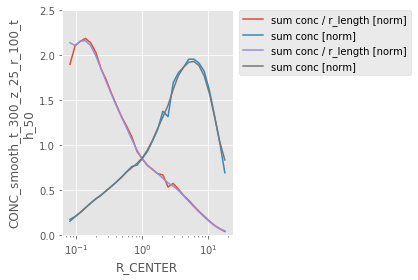

In [99]:
ax_ops = { 'ylim' : (0 , 2.5) , 'xscale' : 'log' }
_ , ax = plt.subplots()
plot_conc_over_distance( ds , ax=ax , ax_ops=ax_ops )
plot_conc_over_distance( ds , ax=ax , ax_ops=ax_ops ,
                         conc_lab=conc_smooth_name )
ax.legend( bbox_to_anchor=(1.04 , 1) , borderaxespad=0 )
ax.set( **ax_ops )
ax.figure.tight_layout()
plt.show()

In [100]:
r_length = get_r_length( ds )
ds = ds.assign_coords( **{ 'r_length' : r_length } )

In [101]:
con_smooth_norm_r = ds[ conc_smooth_name ] / ds[ 'r_length' ]
conc_smooth_norm_r_name = 'conc_smooth_norm_r'
ds[ conc_smooth_norm_r_name ] = con_smooth_norm_r

In [102]:
c_sum_r = ds[ conc_smooth_norm_r_name ].sum(
    [ co.RL , co.ZM , co.TH_CENTER ] )
ds_over_r: xr.DataArray = ds[ conc_smooth_norm_r_name ] / c_sum_r
conc_smooth_norm = CONC_SMOOTH_NORM
desc = '''conc divided by the sum at each radial length. also smoothed'''
ds_over_r = ds_over_r.assign_attrs( desc=desc )
ds[ conc_smooth_norm ] = ds_over_r

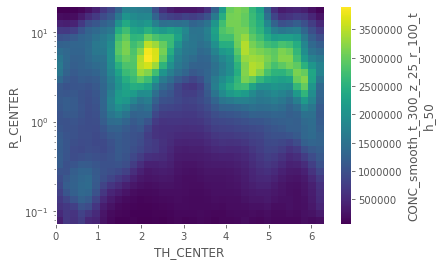

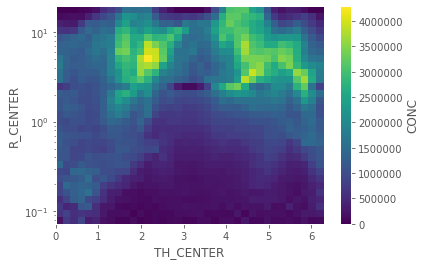

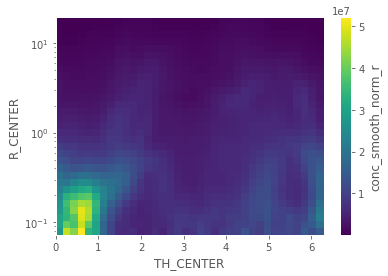

In [103]:
ds[ conc_smooth_name ].sum( [ co.RL , co.ZM ] ).plot( yscale='log' )
plt.show()
ds[ co.CONC ].sum( [ co.RL , co.ZM ] ).plot( yscale='log' )
plt.show()
ds[ conc_smooth_norm_r_name ].sum( [ co.RL , co.ZM ] ).plot( yscale='log' )
plt.show()

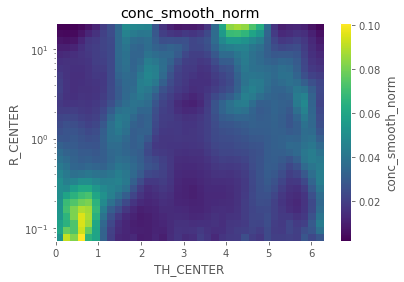

In [104]:
ds[ conc_smooth_norm ].sum( [ co.RL , co.ZM ] ).plot( yscale='log' )
plt.gca().set_title( conc_smooth_norm )
plt.show()

In [105]:
# da: xr.DataArray = ds[ co.CONC ]
# ds[ co.CONC ] = da.where( ~da.isnull() , 0 )

In [106]:
ds = get_con_norm_r_with_mask_over_threshold(
    ds ,
    conc_label=conc_smooth_norm
    )

2019-12-13 18:58:46,969 useful_scit  WARNING  values counts are:
False    24900
True      8580
Name: above_thre, dtype: int64
False    24900
True      8580
Name: above_thre, dtype: int64


In [107]:
ds[ conc_smooth_norm ]

<xarray.DataArray 'conc_smooth_norm' (releases: 4248, R_CENTER: 31, TH_CENTER: 36, ZMID: 30)>
array([[[[0.000000e+00, ..., 0.000000e+00],
         ...,
         [0.000000e+00, ..., 0.000000e+00]],

        ...,

        [[1.894606e-07, ..., 0.000000e+00],
         ...,
         [3.054691e-07, ..., 0.000000e+00]]],


       ...,


       [[[0.000000e+00, ..., 0.000000e+00],
         ...,
         [0.000000e+00, ..., 0.000000e+00]],

        ...,

        [[0.000000e+00, ..., 0.000000e+00],
         ...,
         [0.000000e+00, ..., 0.000000e+00]]]])
Coordinates:
  * TH_CENTER   (TH_CENTER) float64 0.08727 0.2618 0.4363 ... 5.847 6.021 6.196
  * releases    (releases) datetime64[ns] 2017-12-06 ... 2018-05-31T23:00:00
  * R_CENTER    (R_CENTER) float64 0.08046 0.09633 0.1153 ... 12.43 14.88 17.81
  * ZMID        (ZMID) float64 250.0 750.0 1.25e+03 ... 1.425e+04 1.475e+04
    ZBOT        (ZMID) float64 0.0 500.0 1e+03 ... 1.35e+04 1.4e+04 1.45e+04
    ZLEN_M      (ZMID) float64 500.0 500.0

In [108]:
print_mask_true_false( ds[ conc_smooth_norm ] )

2019-12-13 18:58:51,398 useful_scit  DEBUG    vals true <xarray.DataArray 'conc_smooth_norm' ()>
array(26.350109)
DEBUG:useful_scit:vals true <xarray.DataArray 'conc_smooth_norm' ()>
array(26.350109)
2019-12-13 18:58:54,412 useful_scit  DEBUG    vals false <xarray.DataArray 'conc_smooth_norm' ()>
array(4.649891)
DEBUG:useful_scit:vals false <xarray.DataArray 'conc_smooth_norm' ()>
array(4.649891)


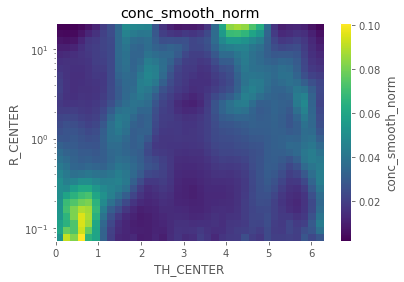

In [109]:
plot_conc_norm_r( ds[ conc_smooth_norm ] )

In [110]:
# df_ , ds = multi_smoothing( ds )
# ds: xr.Dataset
# # %%
# smooth_dict = df_.to_dict()
# ds = ds.assign_attrs( **{ 'smooth_dict' : smooth_dict } )
# chosen_smooth = 'chosen_smooth'
# th__ = {
#     chosen_smooth :
#         'CONC_norm_r_smooth_t_300_z_50_r_100_th_50'
#     }
# ds = ds.assign_attrs( **th__ )
# # %%
# multi_smooth_plot( CONC_norm_r , df_ , ds )

In [111]:
# dss: xr.DataArray = ds[ ds.attrs[ chosen_smooth ] ]
dss: xr.DataArray = ds[ conc_smooth_norm ]
dss_above: xr.DataArray = dss.where( dss[ co.above_thre_label ] )

In [112]:

_da = dss_above.reset_coords( drop=True )
_df = _da.to_dataset( dim=co.RL ).to_dataframe()

In [113]:
log.ger.debug( len( _df ) )
_df1 = _df.dropna( axis=0 , how='all' )
log.ger.debug( len( _df1 ) )

2019-12-13 18:59:38,694 useful_scit  DEBUG    33480
DEBUG:useful_scit:33480
2019-12-13 18:59:39,582 useful_scit  DEBUG    8580
DEBUG:useful_scit:8580


In [114]:
scaler = RobustScaler(
    with_centering=False , quantile_range=(0 , 95) )
scaler = QuantileTransformer()
_dft = scaler.fit_transform( _df1.T ).T

In [115]:
_dft

array([[0.06707086, 0.06692947, 0.06628414, ..., 0.01329546, 0.00992348,
        0.00162335],
       [0.06880904, 0.06802345, 0.06705515, ..., 0.01157104, 0.00896657,
        0.        ],
       [0.15311669, 0.14314436, 0.13106497, ..., 0.00932512, 0.00975556,
        0.01014438],
       ...,
       [0.97906201, 0.98035976, 0.98282297, ..., 0.        , 0.        ,
        0.        ],
       [0.98102895, 0.98310095, 0.98704288, ..., 0.        , 0.        ,
        0.        ],
       [0.97763017, 0.98080513, 0.9840051 , ..., 0.        , 0.        ,
        0.        ]])

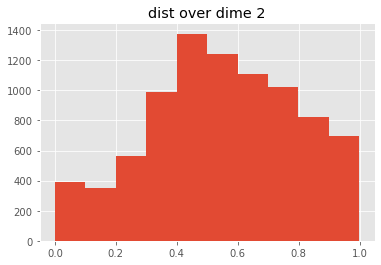

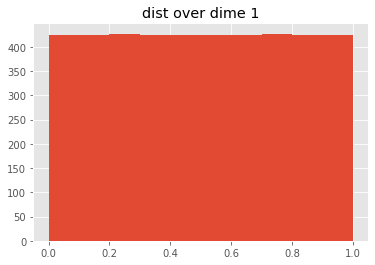

In [116]:
plt.hist( _dft[ : , 23 ] )
plt.gca().set_title( 'dist over dime 2' )
plt.show()
plt.hist( _dft[ 23 ] )
plt.gca().set_title( 'dist over dime 1' )
plt.show()

In [117]:
print( _dft[ 23 ].shape )
print( _dft[ : , 23 ].shape )

(4248,)
(8580,)


In [118]:
log.ger.debug( f'shape of dft {_dft.shape}' )

2019-12-13 18:59:57,825 useful_scit  DEBUG    shape of dft (8580, 4248)
DEBUG:useful_scit:shape of dft (8580, 4248)


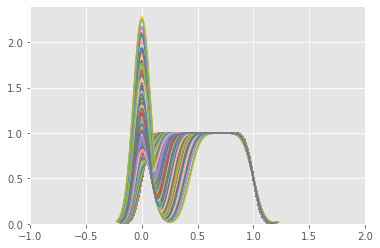

In [119]:
plot_distplot_scaled_vectors( _dft )

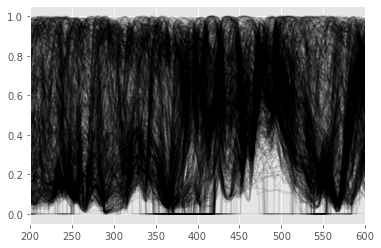

In [120]:
plot_distplot_scaled_v2( _dft )
# df_uns = df_conc.unstack(level=0)

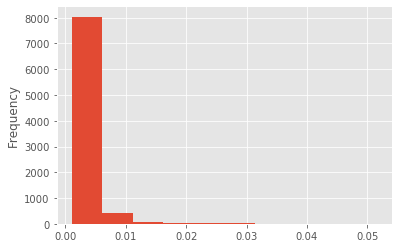

In [121]:
df__sum = plot_sum_hist_df( _df1 )
n_clusters = 18

k_means = KMeans(
    n_clusters=n_clusters , random_state=0 )

k_means = k_means.fit( _dft , sample_weight=df__sum )
labels_ = k_means.labels_

In [122]:
log.ger.debug( f'labels shape: {labels_.shape}' )

2019-12-13 19:01:33,994 useful_scit  DEBUG    labels shape: (8580,)
DEBUG:useful_scit:labels shape: (8580,)


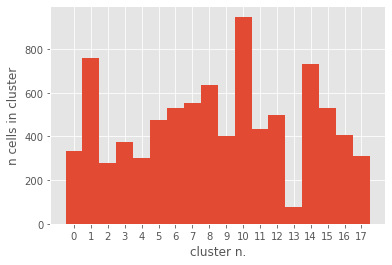

In [123]:
plt.hist( labels_ , bins=np.arange( -.5 , n_clusters + .5 , 1 ) )
ax: plt.Axes = plt.gca()
ax.set_xticks( range( n_clusters ) )
ax.set_xlabel( 'cluster n.' )
ax.set_ylabel( 'n cells in cluster' )
plt.show()

In [124]:
# ds_reset_coords = ds[ ds.attrs[ chosen_smooth ] ].reset_coords(
# drop=True )
ds_reset_coords = ds[ conc_smooth_norm ].reset_coords( drop=True )
_df = ds_reset_coords.to_dataset( co.RL ).to_dataframe()

In [125]:
_df_t_full = scaler.fit_transform( _df.T ).T

In [126]:
df_scaled: pd.DataFrame = _df.copy()
df_scaled[ : ] = _df_t_full

In [127]:
df_scaled.columns.name = co.RL
df_stacked = df_scaled.stack()

In [128]:
df_stacked.isnull().value_counts()

False    142223040
dtype: int64

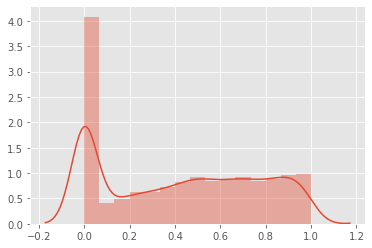

In [129]:
df_over_zero = df_stacked[ df_stacked > -1 ]
sns.distplot( df_over_zero.sample( 10000 ) )
plt.show()

In [130]:
# this line take too long to run for some reason
# ds[ 'scaled' ] = df_stacked.to_xarray()

In [131]:
full = _df_t_full.copy()
full[ ~(full > 0) ] = 0

In [132]:
labs = k_means.predict( full )

In [133]:
lab_df = _df[ [ ] ].copy()
lab_df[ 'lab' ] = labs
lab_df

lab
R_CENTER  TH_CENTER ZMID        
0.080460  0.087266  250.0      7
                    750.0      7
                    1250.0     7
                    1750.0     7
                    2250.0     7
...                          ...
17.814274 6.195919  12750.0    9
                    13250.0    9
                    13750.0   10
                    14250.0   10
                    14750.0   10

[33480 rows x 1 columns]

In [134]:
ds[ 'lab' ] = lab_df[ 'lab' ].to_xarray()

In [135]:
lab__sum = ds.groupby( 'lab' ).sum()

/homeappl/home/aliagadi/appl_taito/miniconda3/envs/b36backup/lib/python3.6/site-packages/xarray/core/groupby.py:833: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  allow_lazy=True, **kwargs)


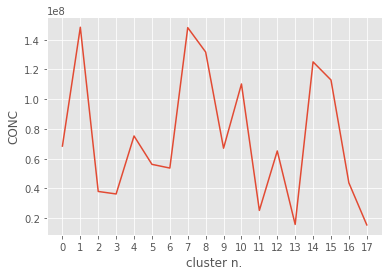

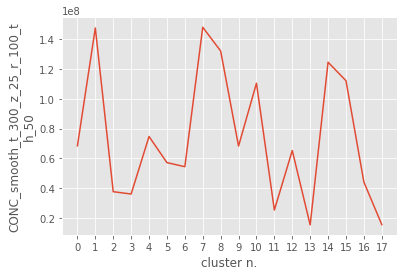

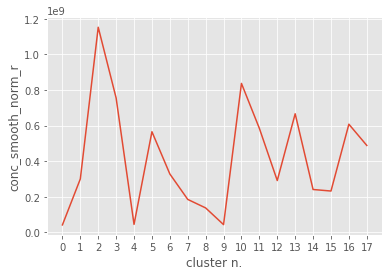

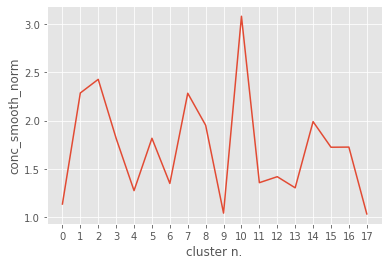

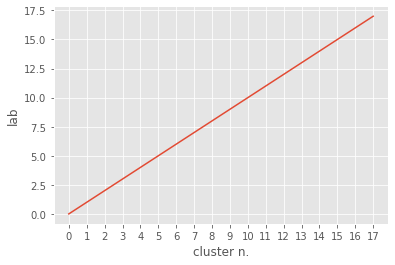

In [136]:
ds_vars = list( lab__sum.variables )
for v in ds_vars :
    lab__sum[ v ].plot()
    ax: plt.Axes = plt.gca()
    ax.set_xticks( range( n_clusters ) )
    ax.set_xlabel( 'cluster n.' )
    # ax.set_ylabel('n cells in cluster')
    plt.show()

In [137]:
selfFLP.save_ds_version(
    ds=ds ,
    file_name='ds_clustered_18.nc' ,
    attrs={ 'clustered' : 1 , 'n_clusters' : 8 }
    )

/homeappl/home/aliagadi/saltena_2018/flexpart_management/flexpart_management/modules/clustering_funs.py:1095: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


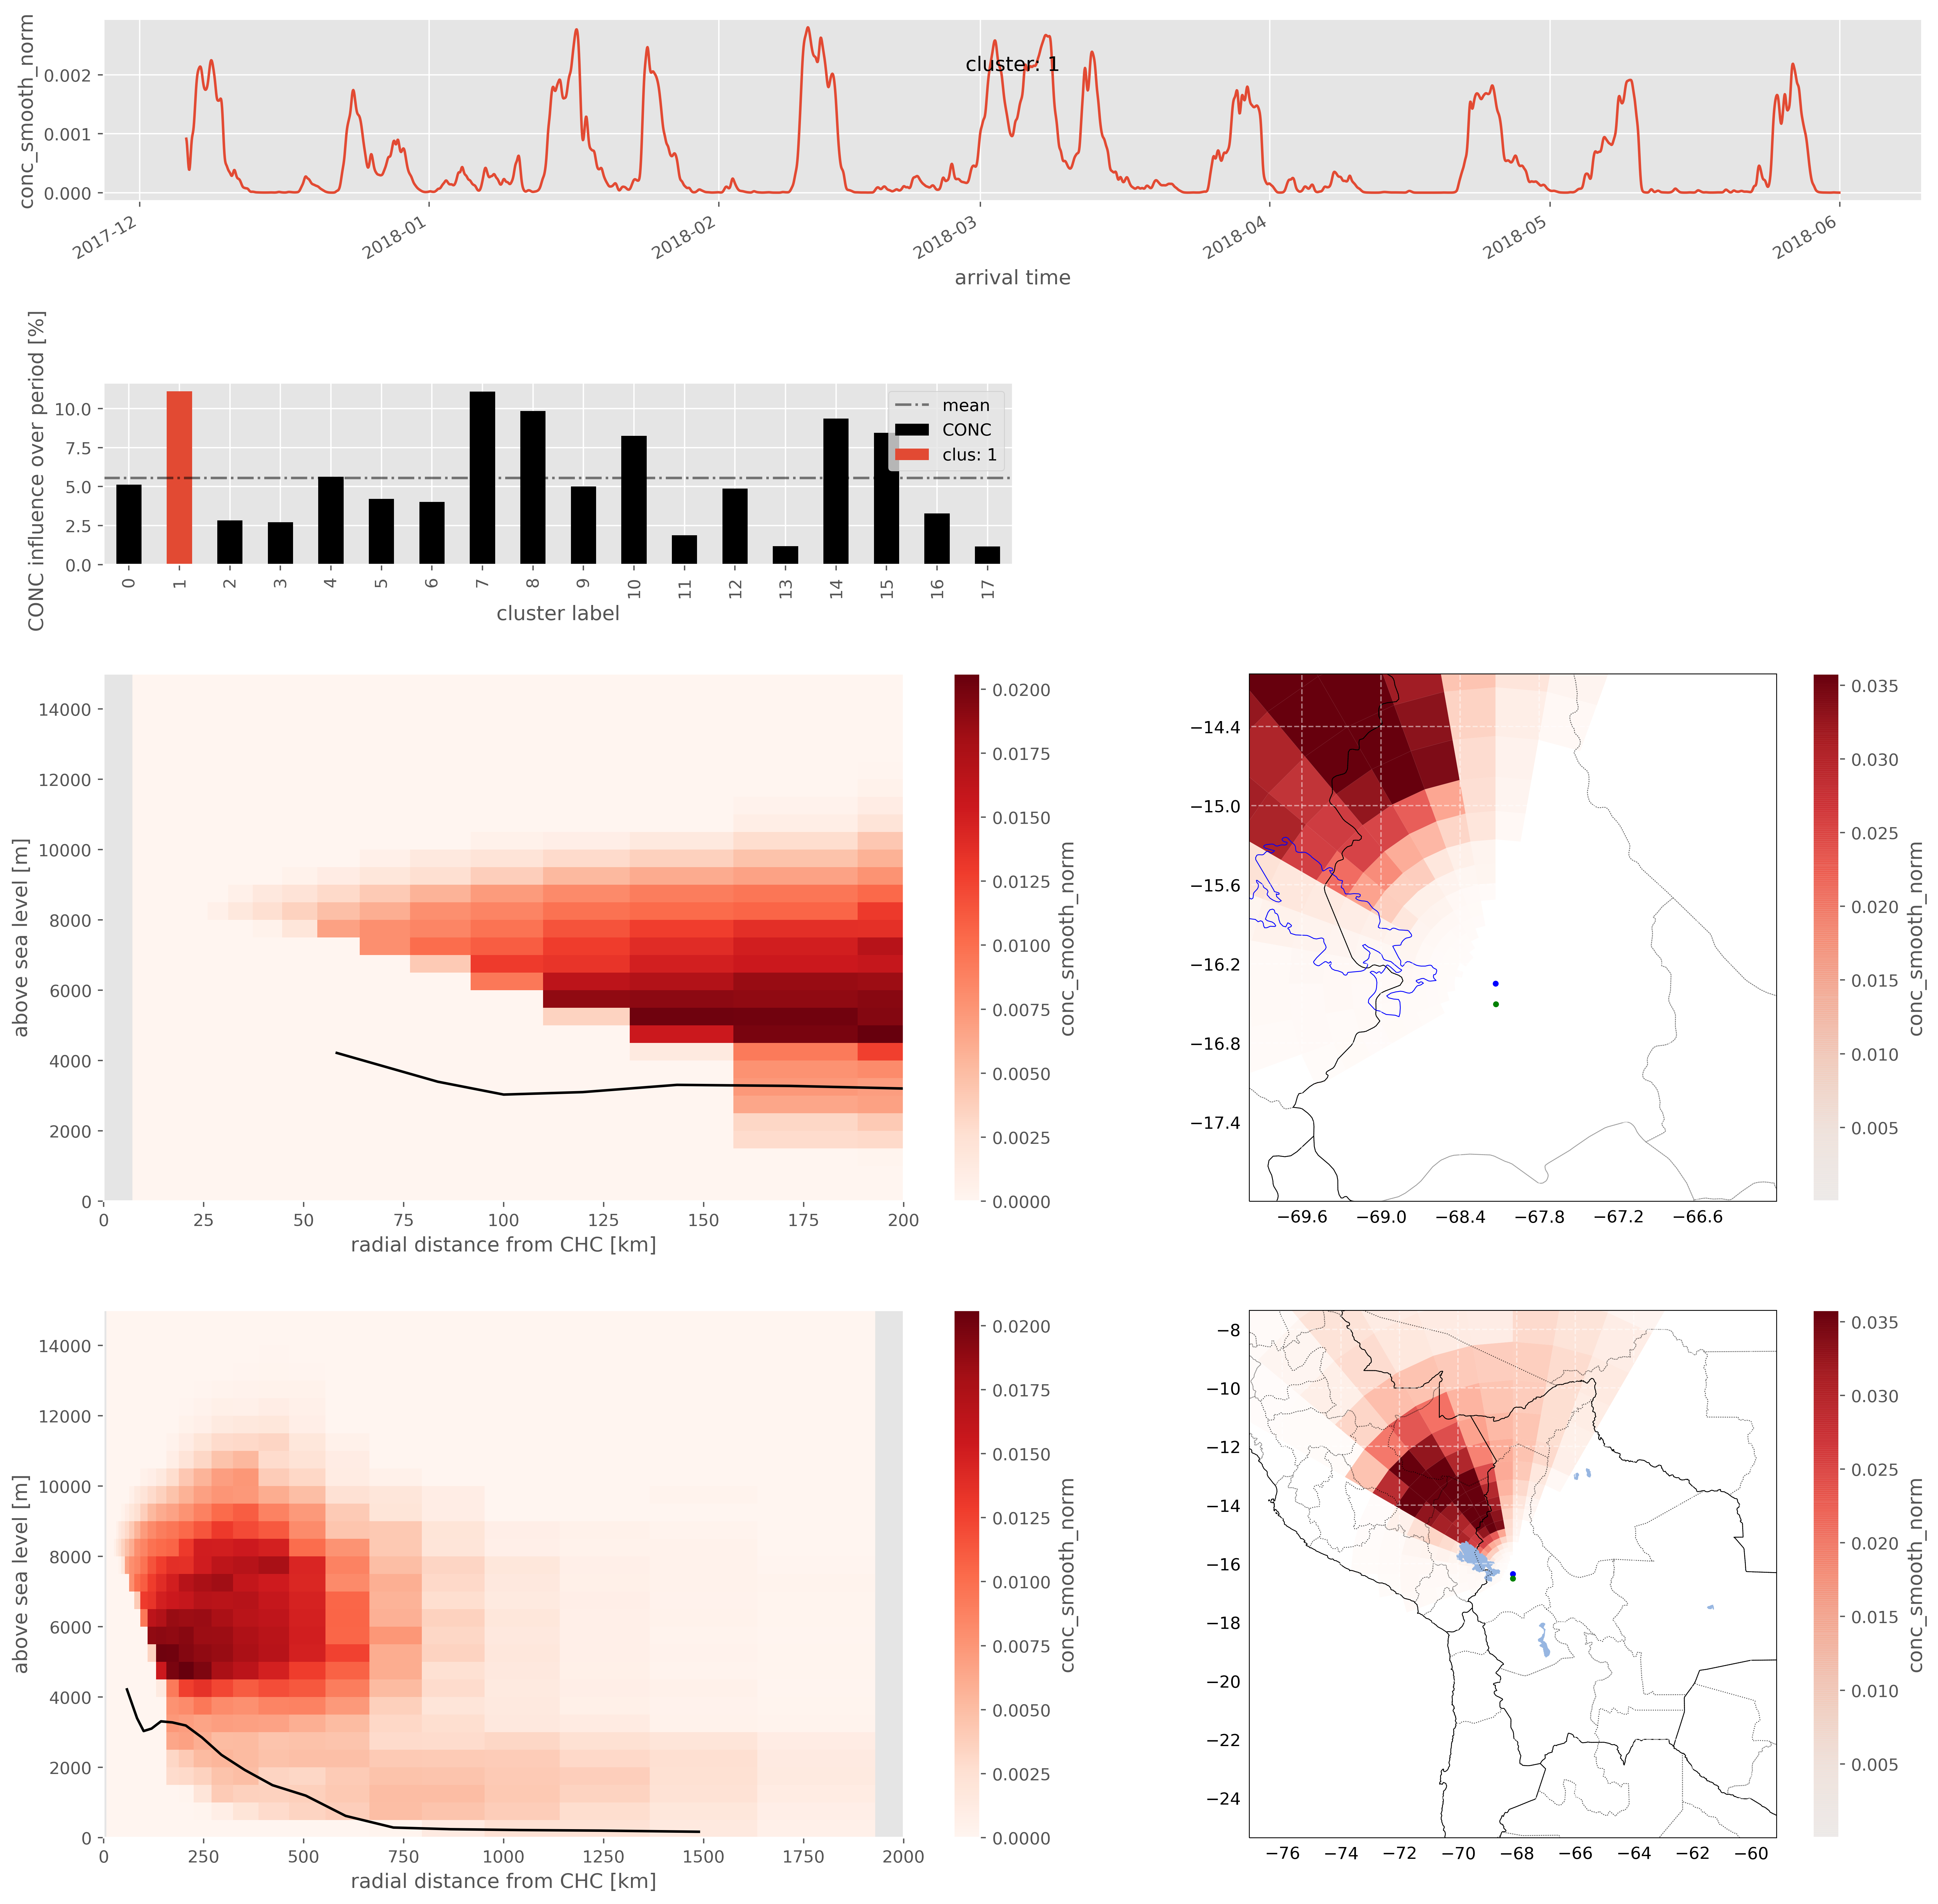

/homeappl/home/aliagadi/saltena_2018/flexpart_management/flexpart_management/modules/clustering_funs.py:1095: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


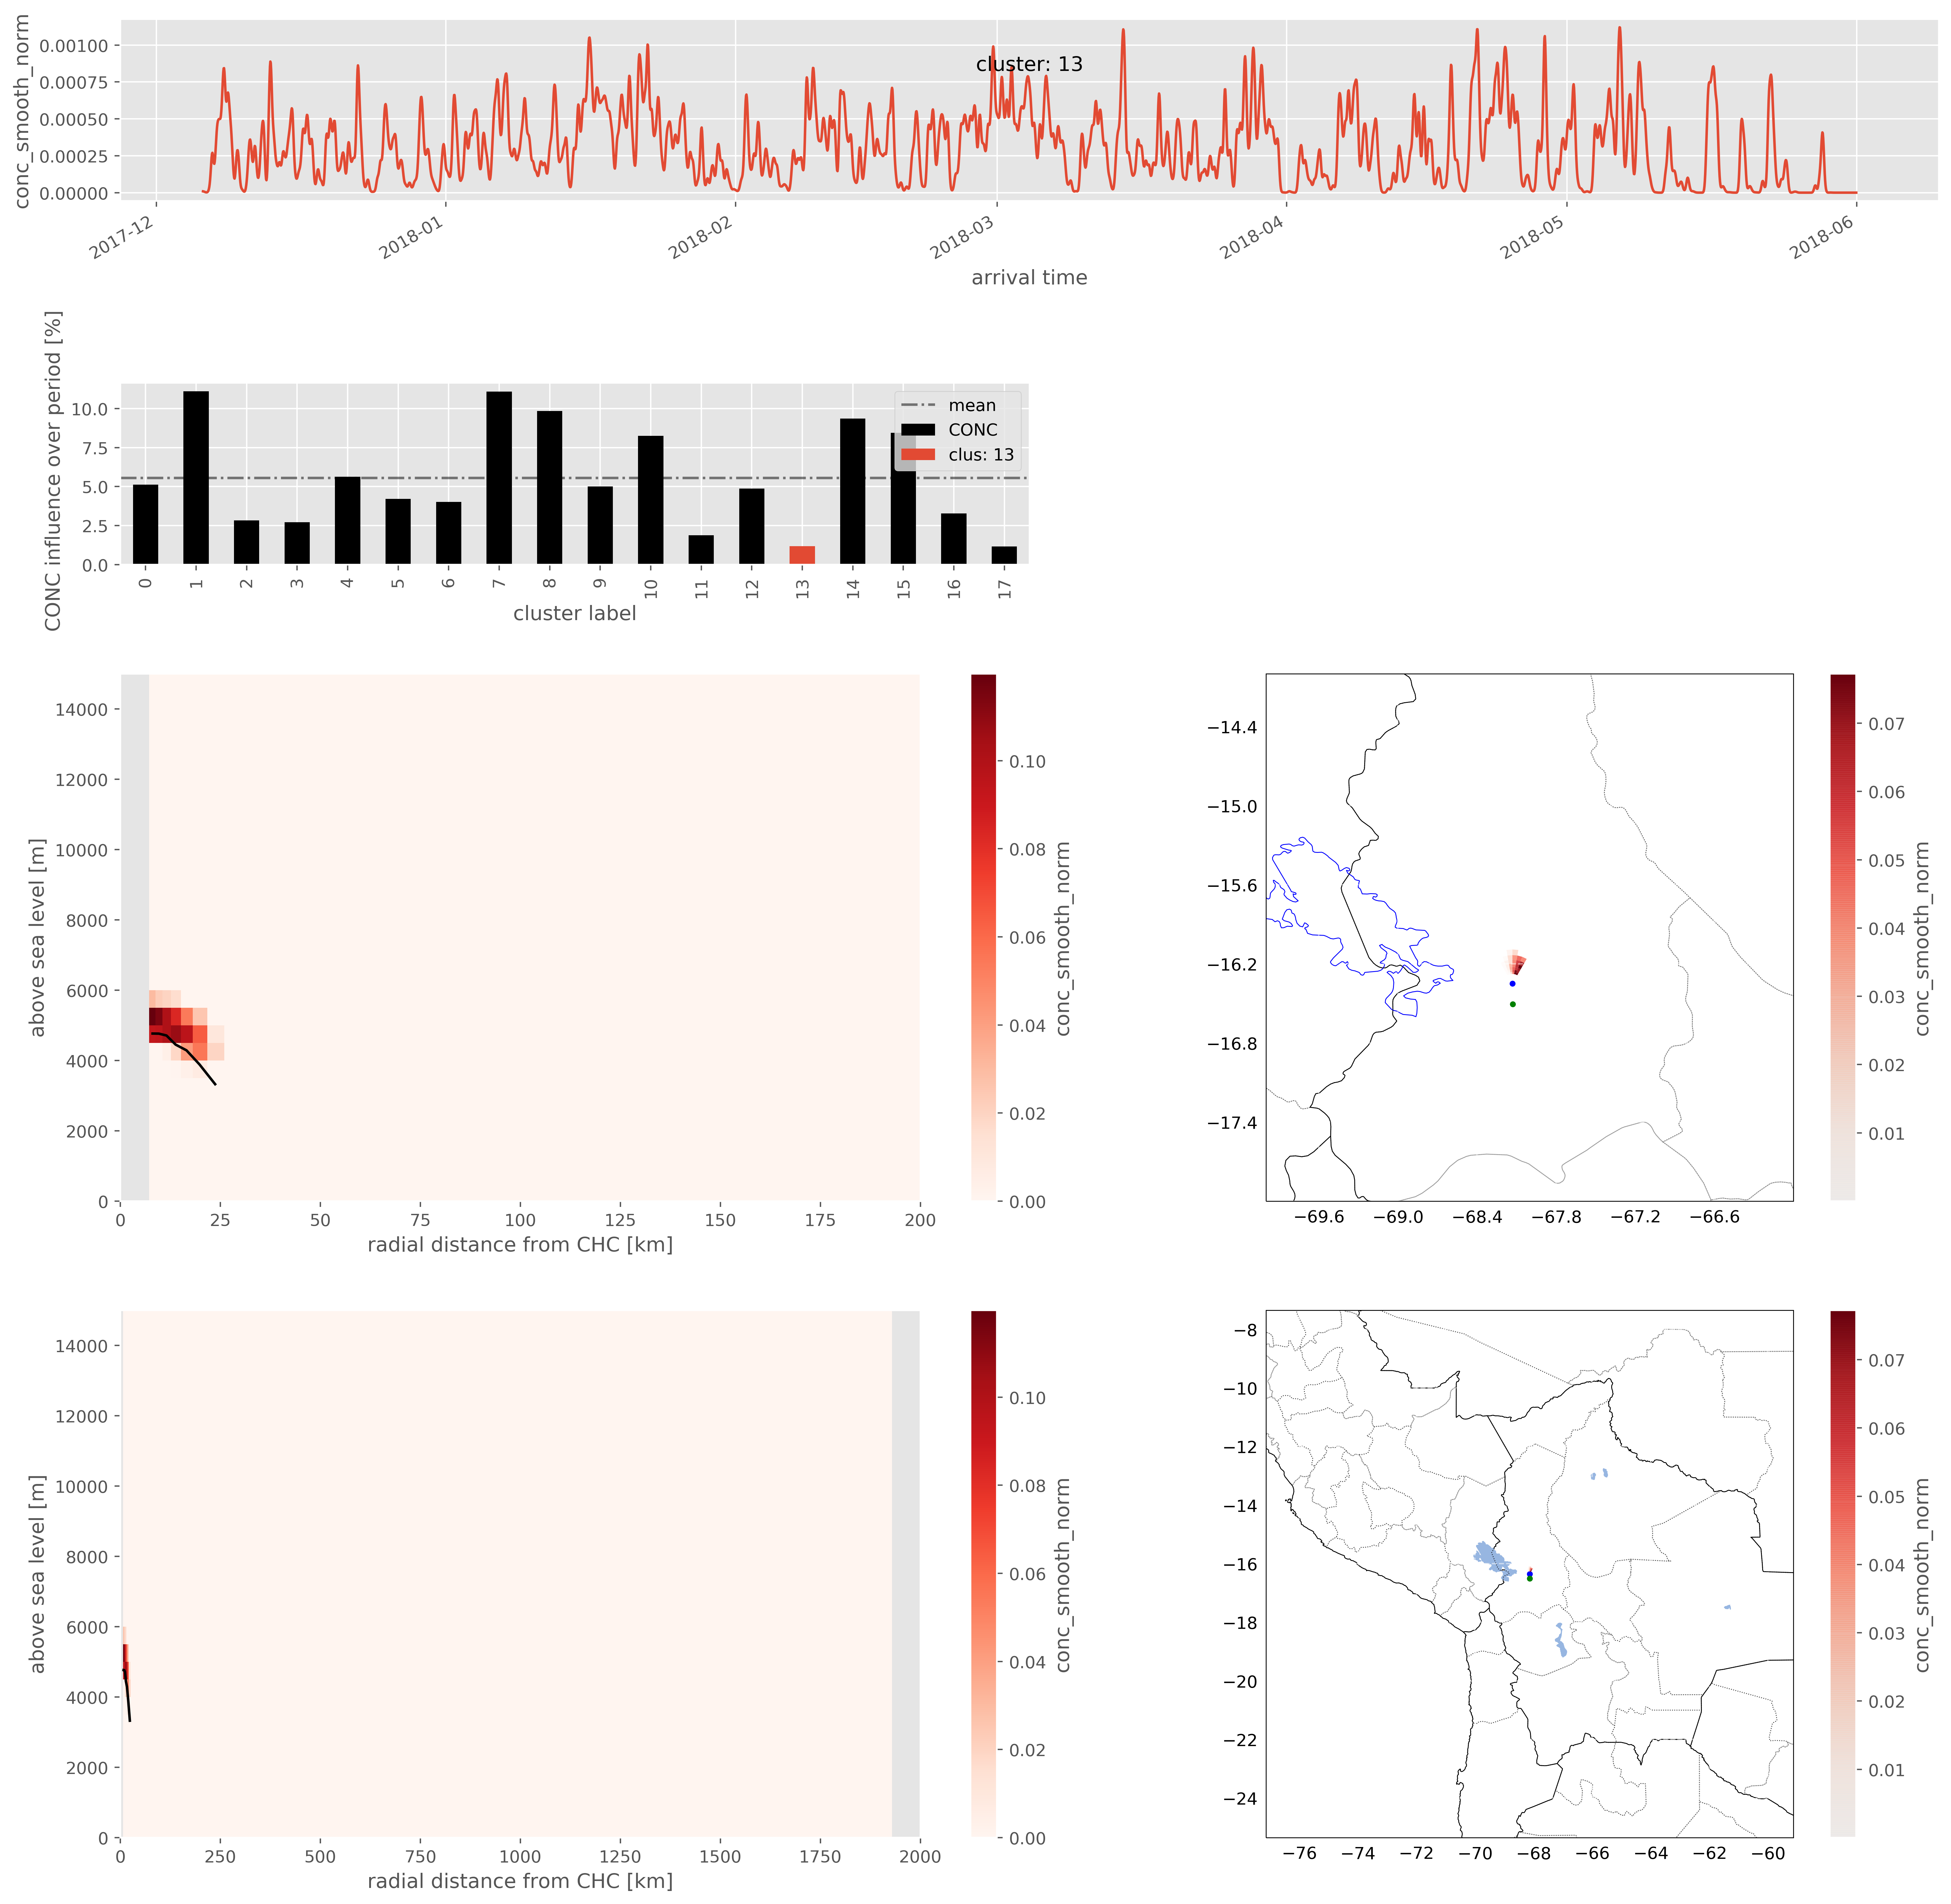

/homeappl/home/aliagadi/saltena_2018/flexpart_management/flexpart_management/modules/clustering_funs.py:1095: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


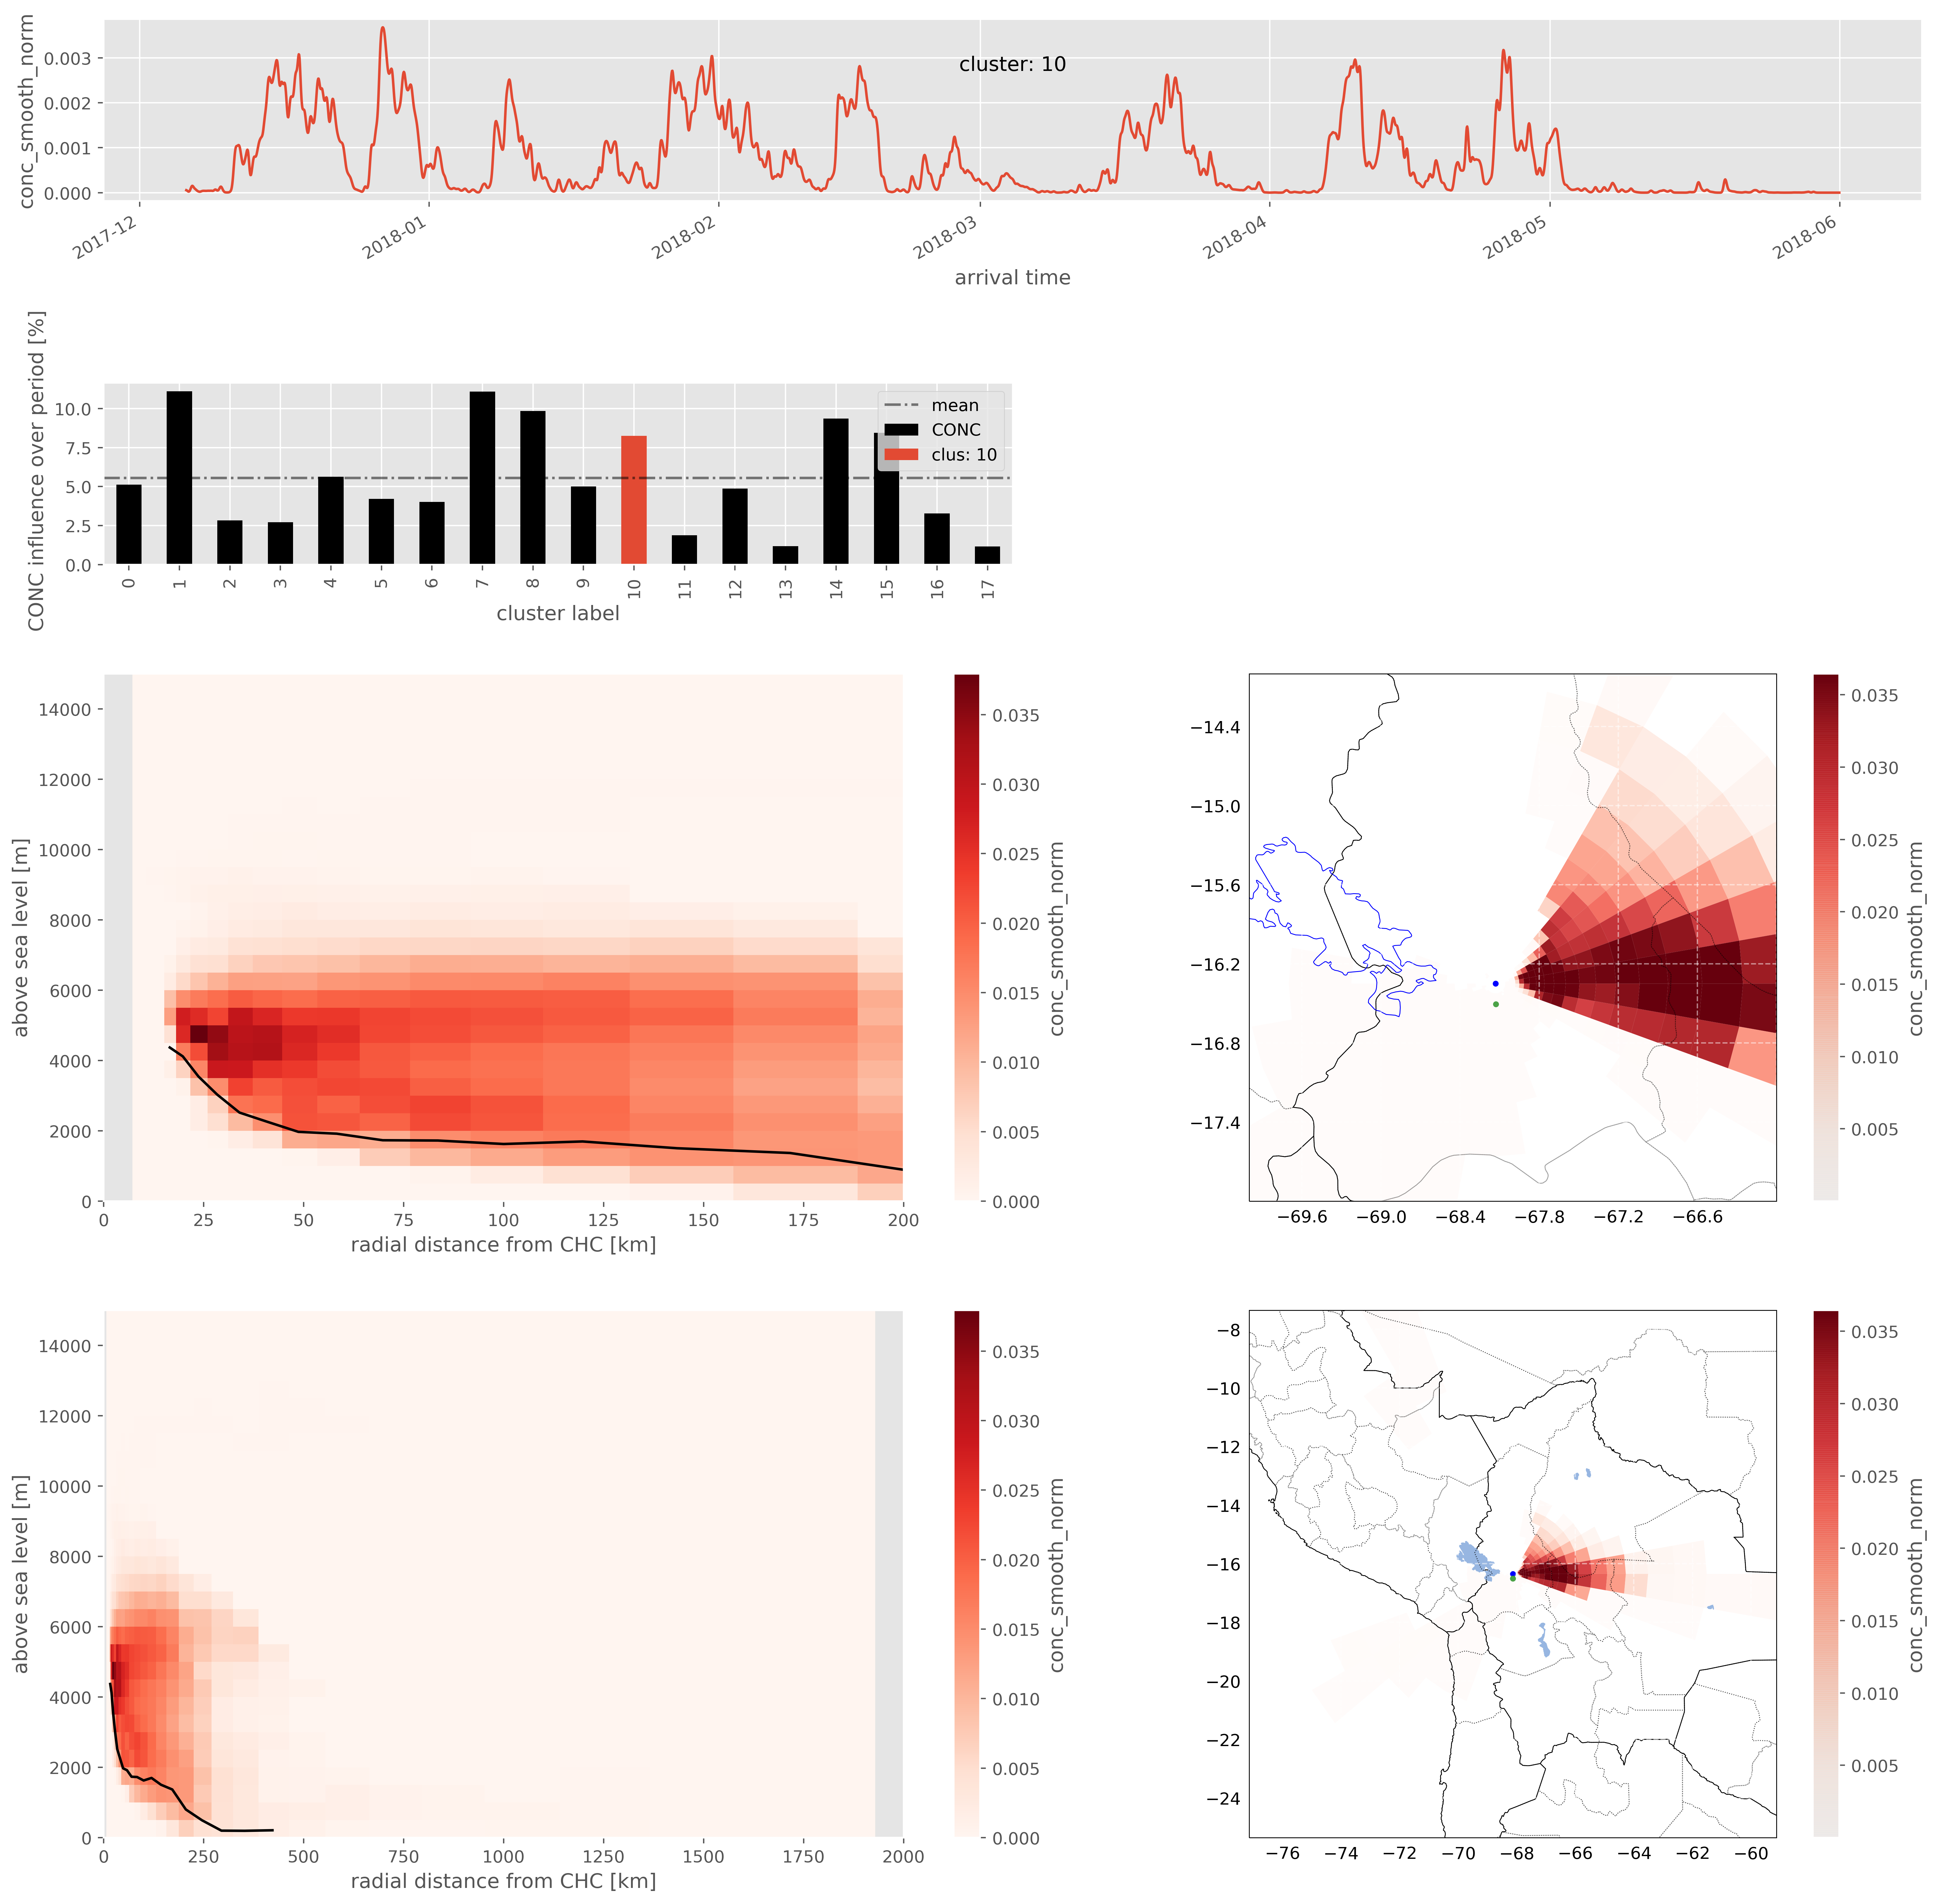

In [138]:
# for i in range( n_clusters ) :
for i in [ 1 , 13 , 10 ] :
    clus_plot( i ,
               ds ,
               # conc_lab= co.CC,
               conc_lab=conc_smooth_norm ,
               )

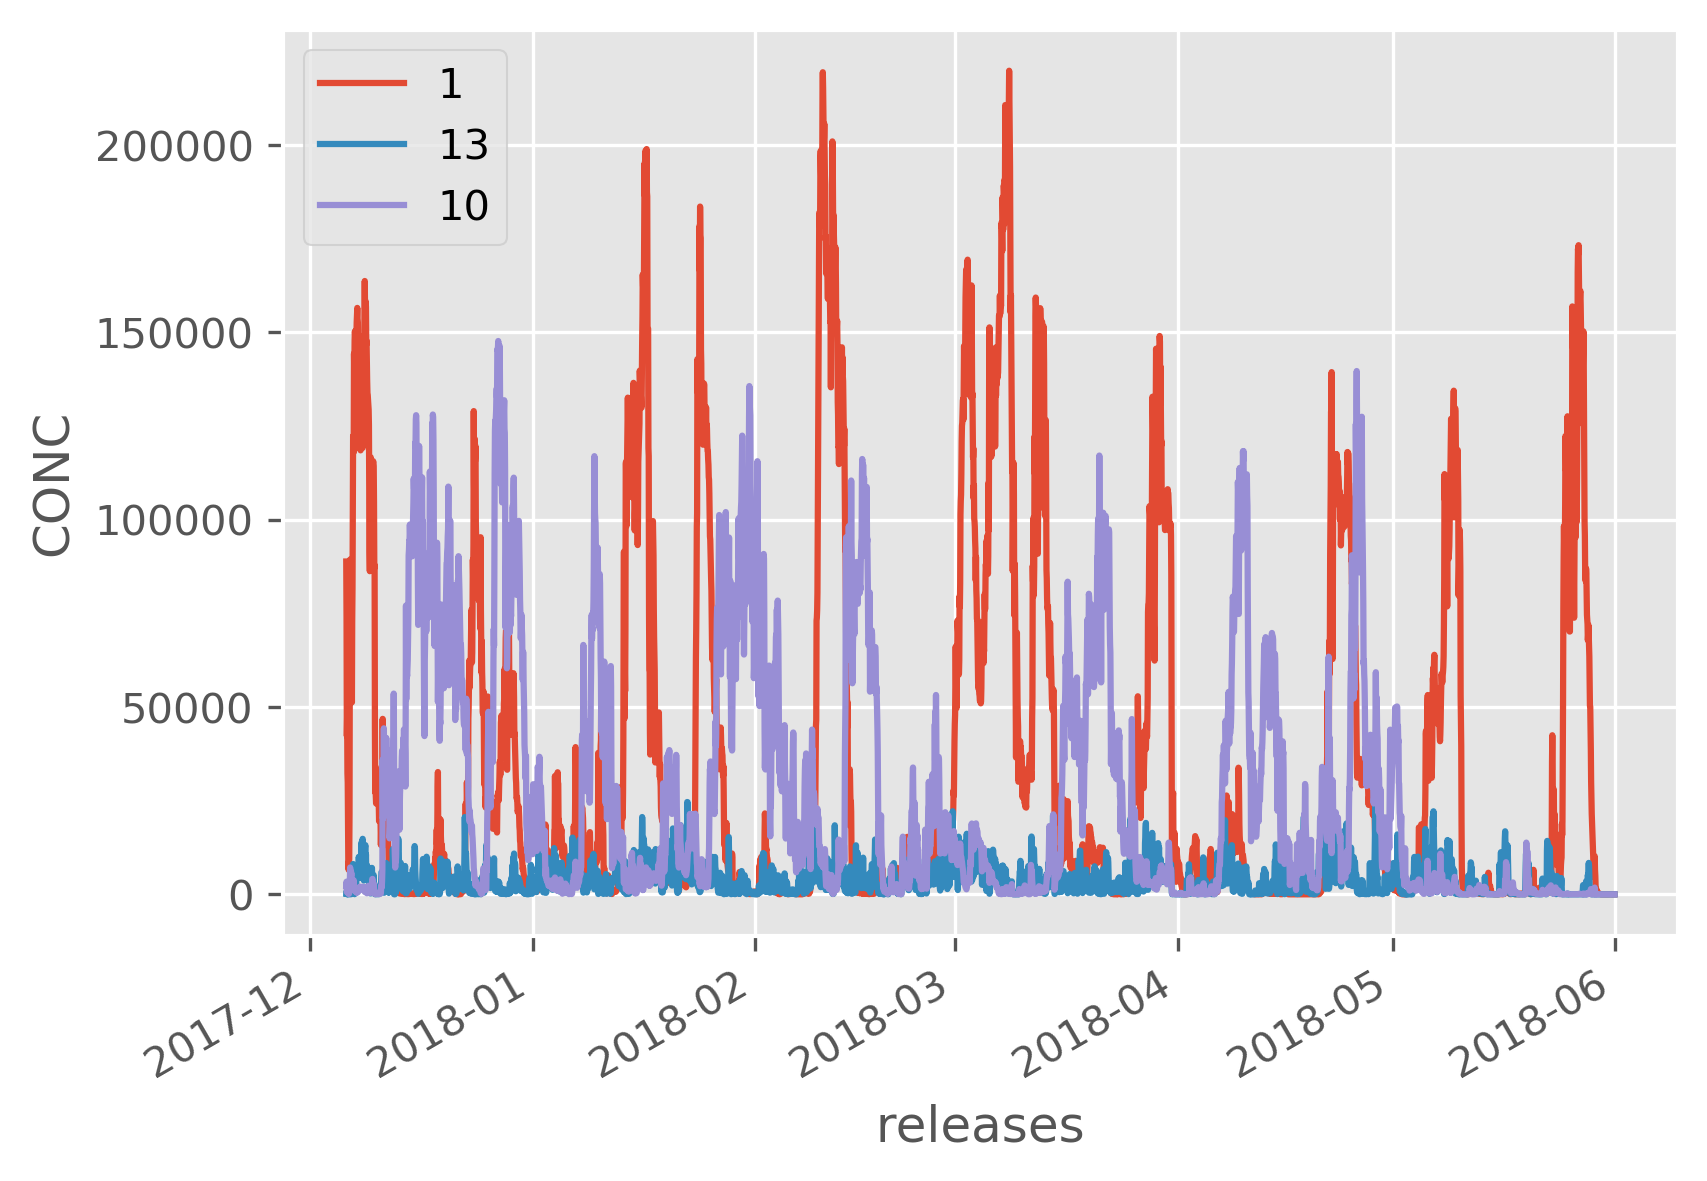

In [139]:

plt.figure( dpi=300 )
# for i in range( n_clusters ) :
for i in [ 1 , 13 , 10 ] :
    dl: xr.DataArray = ds.where( ds[ 'lab' ] == i )[ co.CONC ]
    dl = dl.sum( [ co.TH_CENTER , co.R_CENTER , co.ZM ] )
    dl.plot( label=i )
plt.gca().legend()
plt.show()

In [ ]:

# main()